[ref](https://qiskit.org/documentation/apidoc/aer_noise.html)

In [1]:
import sys
sys.path.extend(['/home/quic/QUIC-Projects'])


# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
from classifiers.datasets.dataloader import Example_4x2
# for QASVM
from classifiers.quantum import Qasvm_Mapping_4x2
from classifiers.quantum.qasvm import QASVM
from classifiers.quantum.quantum_circuits import AnsatzCircuit9
from classifiers.optimizer import tSPSA
from qiskit.utils import QuantumInstance
from qiskit.ignis.mitigation import CompleteMeasFitter
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, NLocal, TwoLocal
from qiskit.providers.aer import AerSimulator

# for logging & visualization
import logging
from classifiers.callback import CostParamStorage
from torch.utils.tensorboard import SummaryWriter
from classifiers.visualization import Plot_Data, Plot_Log_From_SPSA, Plot_SVM, compare_svm_and_qasvm


from qiskit import Aer
import qiskit.providers.aer.noise as noise
from qiskit.utils import QuantumInstance

from classifiers.datasets import IrisDataset
from classifiers.quantum.ansatz import sample_circuit, MultilayerCircuit9FeatureMap, SingleQubitFeatureMap
from classifiers.quantum.qasvm import NormQSVM

import numpy as np 
from matplotlib import pyplot as plt

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# TODO: choose config
I_HAVE_ACCESS = True # True
DATA_TYPE = 'balanced' # 'unbalanced'
DEVICE = 'montreal' # 'toronto'
TEST_SIZE = 30
MAXITER = 1024
LAST_AVG = 2**4
ERROR = 10**(-3)

C=None
k=1

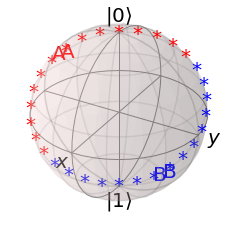

In [3]:
%matplotlib inline
_EPS = 0.01
X, y = Example_4x2(DATA_TYPE=='balanced')()
ax = plt.axes(projection='3d')

from qiskit.visualization.bloch import Bloch
B = Bloch(axes=ax)

def s2c(x):
    bloch = [1, x[0], x[1]]
    r, theta, phi = bloch[0], bloch[1], bloch[2]
    bloch[0] = r * np.sin(theta) * np.cos(phi)
    bloch[1] = r * np.sin(theta) * np.sin(phi)
    bloch[2] = r * np.cos(theta)
    return bloch

def c2s(bloch):
    x = [np.arccos(bloch[2]), np.arctan(bloch[1]/bloch[0])]
    return x

vecs = np.array(list(map(s2c, X)))
for v in vecs[y==0]:
    B.add_annotation(v, text='A', color='r')
for v in vecs[y==1]:
    B.add_annotation(v, text='B', color='b')
# B.add_annotation(vecs.mean(axis=0), text='M', color='k')
vecA = vecs[y==0].mean(axis=0)
vecA = vecA/np.linalg.norm(vecA)
vecB = vecs[y==1].mean(axis=0)
vecB = vecB/np.linalg.norm(vecB)
vecP = (vecA-vecB)/np.linalg.norm(vecA-vecB)
vecQ = -(vecA-vecB)/np.linalg.norm(vecA-vecB)
#B.add_annotation(vecP, text='P', color='r')
#B.add_annotation(vecQ, text='Q', color='b')

def test_data_gen(n, vecP, vecQ):
    Xt = np.array([np.linspace(0, 2*np.pi, n+1), c2s(vecP)[1]*np.ones(n+1)]).T
    Xt = Xt[1:]
    yt = np.where(np.dot(np.array(list(map(s2c, Xt))), vecP-vecQ)<0, 1, 0)
    return Xt, yt

Xt, yt = test_data_gen(TEST_SIZE, vecP, vecQ)

vecs = np.array(list(map(s2c, Xt)))
for v in vecs[yt==0]:
    B.add_annotation(v, text='*', color='r')
for v in vecs[yt==1]:
    B.add_annotation(v, text='*', color='b')

B.render()

In [4]:
# Error probabilities
prob_1 = ERROR  # 1-qubit gate
prob_2 = min([10*prob_1, 0.5]) # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['rz', 'sz', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

In [5]:
noisy_quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), basis_gates=basis_gates, noise_model=noise_model, shots=2**13)

"""feature_map1 = Circuit9(4, reps=1)
feature_map = feature_map1.copy()
for _ in range(2 - 1):
    feature_map.compose(feature_map1, inplace=True)
sCircuit = sample_circuit(15)
var_form = sCircuit(int(np.log2(64)), reps=6)
noisy_qasvm = NormQSVM(
    X, y, lamda=1,
    quantum_instance=noisy_quantum_instance,
    var_form=var_form,
    feature_map=feature_map
)"""


'feature_map1 = Circuit9(4, reps=1)\nfeature_map = feature_map1.copy()\nfor _ in range(2 - 1):\n    feature_map.compose(feature_map1, inplace=True)\nsCircuit = sample_circuit(15)\nvar_form = sCircuit(int(np.log2(64)), reps=6)\nnoisy_qasvm = NormQSVM(\n    X, y, lamda=1,\n    quantum_instance=noisy_quantum_instance,\n    var_form=var_form,\n    feature_map=feature_map\n)'

In [6]:
var_form = RealAmplitudes(3, reps=2)
gis = 0.01 * np.random.normal(size=X.shape)
feature_map = SingleQubitFeatureMap(2, 2)
qasvm = NormQSVM(np.vstack([X, X+gis]), np.concatenate([y, y]), quantum_instance=noisy_quantum_instance, var_form=var_form, feature_map=feature_map, lamda=k)
print(qasvm.second_order_circuit.depth())
print(qasvm.first_order_circuit.depth())
"""import dill
with open('./ibmq_run_device_2/balanced/mumbai/sim_qasvm', 'rb') as f:
    qasvm = dill.load(f)
qasvm._quantum_instance = noisy_quantum_instance"""

249
249


"import dill\nwith open('./ibmq_run_device_2/balanced/mumbai/sim_qasvm', 'rb') as f:\n    qasvm = dill.load(f)\nqasvm._quantum_instance = noisy_quantum_instance"

In [7]:
from tqdm.notebook import tqdm

storage = CostParamStorage()
optimizer = tSPSA(maxiter=MAXITER, blocking=True, last_avg=LAST_AVG, callback=storage)

for epoch in tqdm(range(1, MAXITER//4 + 1)):
    optimizer.step(qasvm.cost_fn, qasvm.parameters)
    if storage.num_accepted() > 2 * LAST_AVG and storage.last_cost_avg(2 * LAST_AVG, ignore_rejected=True) < storage.last_cost_avg(LAST_AVG, ignore_rejected=True):
        break

qasvm.parameters = storage.last_avg(LAST_AVG, ignore_rejected=True)
fvec = qasvm.f(Xt)


  0%|          | 0/256 [00:00<?, ?it/s]

In [8]:
svm = BinarySVM(Kernel('SingleQubit', reps=1), mutation='REDUCED_QASVM', C=C, k=k)
svm.fit(X, y)
Xtt, ytt = test_data_gen(100, vecP, vecQ)
svm_fvec = svm.f(Xtt)

Text(0.5, 1.0, 'balanced')

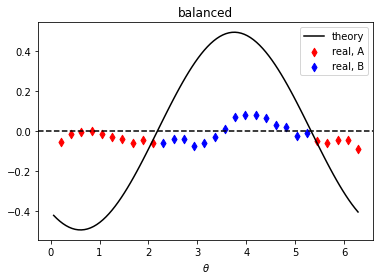

In [9]:
plt.plot(Xtt[:, 0], svm_fvec, color='k', label='theory')
plt.scatter(Xt[yt==0, 0], fvec[yt==0], c='r', marker='d', label='real, A')
plt.scatter(Xt[yt==1, 0], fvec[yt==1], c='b', marker='d', label='real, B')
plt.axhline(0, 0, 1, color='k', linestyle='--')
plt.legend()
plt.xlabel(r'$\theta$')
plt.title(DATA_TYPE)